In [1]:
!nvidia-smi

Sat Sep 30 05:45:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d iashiqul/brain-tumor-mri-image-classification-dataset

 99% 252M/255M [00:12<00:00, 23.2MB/s]
100% 255M/255M [00:12<00:00, 21.6MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('/content/brain-tumor-mri-image-classification-dataset.zip')
zip.extractall('/content')
zip.close()

In [4]:
!ls /content

'Brain Tumor MRI Classfication'
 brain-tumor-mri-image-classification-dataset.zip
 kaggle.json
'MRI Image Dataset for Brain Tumor'
 sample_data


In [5]:
!ls /content/'Brain Tumor MRI Classfication/Brain Tumor MRI Classfication'

Testing  Training  Validation


In [6]:
import os

def get(path):
  list = os.listdir(path)
  for i in list:
    print(i)
    list1 = os.listdir(path + "/" + i)
    for j in list1:
      print(" " , j , len(os.listdir(path + "/" + i  + "/" + j)))

get('/content/MRI Image Dataset for Brain Tumor/MRI Image Dataset for Brain Tumor')






Testing
  notumor 405
  glioma 300
  meningioma 306
  pituitary 300
Validation
  notumor 162
  glioma 175
  meningioma 139
  pituitary 179
Training
  notumor 1595
  glioma 1321
  meningioma 1339
  pituitary 1457


notumor


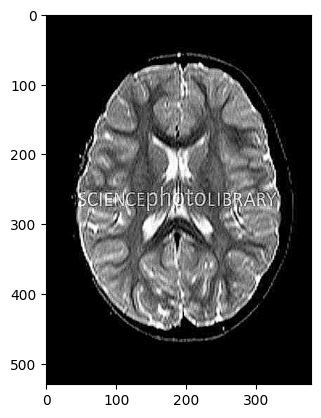

glioma


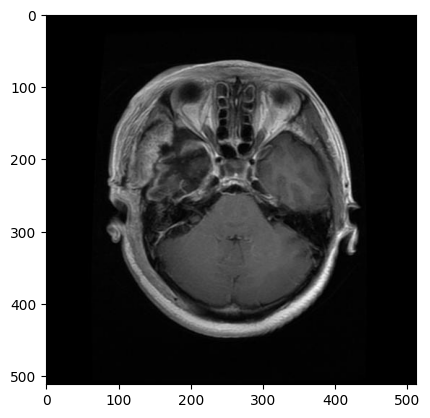

meningioma


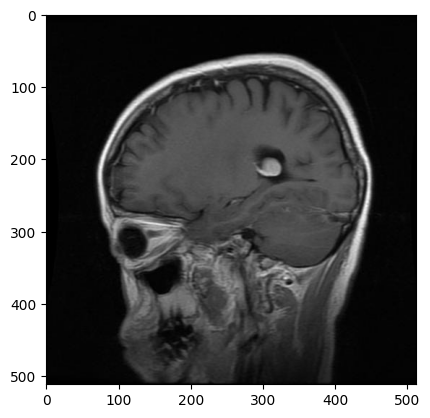

pituitary


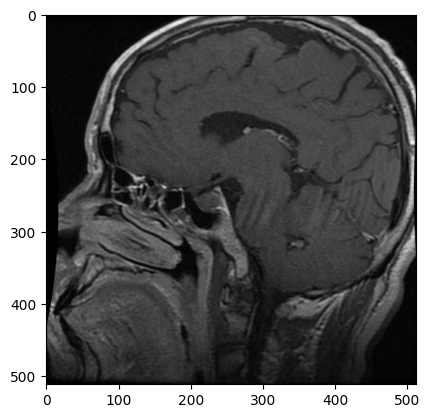

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

def visualize(x):
  list = os.listdir(x)
  for i in list:
    list1 = os.listdir(x + "/" + i)
    img = random.choice(list1)
    img1 = cv2.imread(x + "/" + i + "/" + img)
    print(i)
    plt.imshow(img1)
    plt.show()

visualize('/content/MRI Image Dataset for Brain Tumor/MRI Image Dataset for Brain Tumor/Training')


In [8]:
# Let's take the data

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

trr = image_dataset_from_directory(
    directory = '/content/MRI Image Dataset for Brain Tumor/MRI Image Dataset for Brain Tumor/Training',
    label_mode = 'categorical',
    batch_size = 32,
    image_size = (256 ,  256)

)

classnames = trr.class_names

train = ImageDataGenerator(rescale = 1 / 255.)
test = ImageDataGenerator(rescale = 1 / 255.)
val = ImageDataGenerator(rescale = 1 / 255.)

train_data = train.flow_from_directory(
    directory = '/content/MRI Image Dataset for Brain Tumor/MRI Image Dataset for Brain Tumor/Training',
    batch_size = 32,
    target_size = (256, 256),
    class_mode = 'categorical'
)

test_data = train.flow_from_directory(
    directory = '/content/MRI Image Dataset for Brain Tumor/MRI Image Dataset for Brain Tumor/Testing',
    batch_size = 32,
    target_size = (256, 256),
    class_mode = 'categorical'
)

val_data = train.flow_from_directory(
    directory = '/content/MRI Image Dataset for Brain Tumor/MRI Image Dataset for Brain Tumor/Validation',
    batch_size = 32,
    target_size = (256, 256),
    class_mode = 'categorical'
)

Found 5712 files belonging to 4 classes.
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 655 images belonging to 4 classes.


In [9]:
# Let's make some checkpoints
import datetime

# Early Stopping

def early():
  return tf.keras.callbacks.EarlyStopping(patience = 10 , monitor = 'val_loss' , min_delta =0.001 , restore_best_weights = True)


# Model Checkpoint

def point(path):
  return tf.keras.callbacks.ModelCheckpoint(path , monitor = 'val_loss' , save_best_only= True , save_weights_only=True , save_freq = "epoch")

# TensorBoard

def board(dir , name):
  folder = dir + "/" + name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(log_dir = folder)




In [10]:
from tensorflow.keras.layers import Dense , Conv2D , GlobalAveragePooling2D , MaxPooling2D
from tensorflow.keras import Sequential

In [11]:
base = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet')


83683744/83683744 [==============================] - 3s 0us/step


In [12]:
base.trainable = False

In [13]:
model2 = Sequential()
model2.add(base)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256 , activation = 'relu'))
model2.add(Dense(128 , activation = 'relu'))
model2.add(Dense(64 , activation = 'relu'))
model2.add(Dense(32 , activation = 'relu'))
model2.add(Dense(4 , activation = 'softmax'))

model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [14]:
model2.compile(loss = "categorical_crossentropy" , optimizer ="Adam" , metrics = ['accuracy'])

In [15]:
history2 = model2.fit(train_data , epochs = 50 , validation_data = (test_data) , steps_per_epoch = len(train_data) , validation_steps = len(test_data),
          callbacks = [board("TB" , "transfer") , early() , point("transfer.ckpt")] , use_multiprocessing=True)

Epoch 1/50
179/179 [==============================] - 134s 660ms/step - loss: 0.4497 - accuracy: 0.8260 - val_loss: 0.3471 - val_accuracy: 0.8596
Epoch 2/50
179/179 [==============================] - 117s 649ms/step - loss: 0.2582 - accuracy: 0.9051 - val_loss: 0.3165 - val_accuracy: 0.8856
Epoch 3/50
179/179 [==============================] - 130s 722ms/step - loss: 0.2021 - accuracy: 0.9237 - val_loss: 0.2063 - val_accuracy: 0.9275
Epoch 4/50
179/179 [==============================] - 112s 617ms/step - loss: 0.1700 - accuracy: 0.9366 - val_loss: 0.1901 - val_accuracy: 0.9314
Epoch 5/50
179/179 [==============================] - 110s 613ms/step - loss: 0.1338 - accuracy: 0.9505 - val_loss: 0.1816 - val_accuracy: 0.9314
Epoch 6/50
179/179 [==============================] - 119s 660ms/step - loss: 0.1349 - accuracy: 0.9513 - val_loss: 0.1907 - val_accuracy: 0.9336
Epoch 7/50
179/179 [==============================] - 121s 671ms/step - loss: 0.1106 - accuracy: 0.9580 - val_loss: 0.1930 -

In [16]:
base.trainable = True
for i in base.layers[:-10]:
  i.trainable = False
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [17]:
model2.compile(loss = "categorical_crossentropy" , optimizer ="Adam" , metrics = ['accuracy'])
history2 = model2.fit(train_data , epochs = 50 , validation_data = (test_data) , steps_per_epoch = len(train_data) , validation_steps = len(test_data),
          callbacks = [board("TB" , "transfer") , early() , point("transfer.ckpt")] , use_multiprocessing=True ,
                      initial_epoch = history2.epoch[-1])

Epoch 24/50
179/179 [==============================] - 144s 729ms/step - loss: 0.2926 - accuracy: 0.9016 - val_loss: 0.6793 - val_accuracy: 0.7674
Epoch 25/50
179/179 [==============================] - 102s 560ms/step - loss: 0.1460 - accuracy: 0.9477 - val_loss: 0.2939 - val_accuracy: 0.9138
Epoch 26/50
179/179 [==============================] - 129s 714ms/step - loss: 0.1173 - accuracy: 0.9568 - val_loss: 0.2281 - val_accuracy: 0.9169
Epoch 27/50
179/179 [==============================] - 95s 529ms/step - loss: 0.0819 - accuracy: 0.9739 - val_loss: 0.1302 - val_accuracy: 0.9565
Epoch 28/50
179/179 [==============================] - 128s 710ms/step - loss: 0.0763 - accuracy: 0.9697 - val_loss: 0.1066 - val_accuracy: 0.9641
Epoch 29/50
179/179 [==============================] - 96s 526ms/step - loss: 0.0663 - accuracy: 0.9751 - val_loss: 0.5138 - val_accuracy: 0.8810
Epoch 30/50
179/179 [==============================] - 128s 711ms/step - loss: 0.0450 - accuracy: 0.9842 - val_loss: 0.1

In [18]:
model2.load_weights('transfer.ckpt')

In [19]:
model2.evaluate(test_data)

41/41 [==============================] - 6s 152ms/step - loss: 0.0673 - accuracy: 0.9832


[0.06733006238937378, 0.9832189083099365]

In [20]:
model2.save('BrainTumorClassificationModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
model2.save("mymodel.keras")